## This code will compare NWIS observations with COAWST model output

In [1]:
import dataretrieval.nwis as nwis
import matplotlib.pyplot as plt
import pandas as pd
import pytz
from datetime import datetime, timezone

In [2]:
# specify the USGS site code for which we want data.

# Chester River
site = '01477050'

# get instantaneous values (iv)
# pick start/end dates 
# load specific conductance values - parameter '00095'
# Check NWIS site for parameter #'s : https://help.waterdata.usgs.gov/code/parameter_cd_query?fmt=rdb&inline=true&group_cd=%

df = nwis.get_record(sites=site, service='iv', start='2019-01-01', end='2020-01-01',parameterCd='00095')

In [3]:
df['date'] = pd.to_datetime(df.index,utc=True)

In [4]:
df['date'] = df['date'].dt.tz_localize(None)

In [5]:
# Follow USGS guidance on conversion : 
# Citatiom: Lewis, E.L., 1980, # The Practical Salinity Scale 1978 and its antecedents: IEEE Journal of Oceanic Engineering, v. OE–5, no. 1, p. 3−8.
# described in this USGS report: https://pubs.usgs.gov/tm/2006/tm1D3/pdf/TM1D3.pdf

def convert_to_salinity(df):
    R = df['00095'].values/1000/53.087;
    K1 = 0.012;
    K2 = -0.2174;
    K3 = 25.3283;
    K4 = 13.7714;
    K5 = -6.4788;
    K6 = 2.5842;

    salinity = K1+(K2*R**(1/2))+(K3*R)+(K4*R**(3/2))+(K5*R**2)+(K6*R**(5/2));

    return salinity

In [6]:
df['salinity']=convert_to_salinity(df)

<AxesSubplot:xlabel='datetime'>

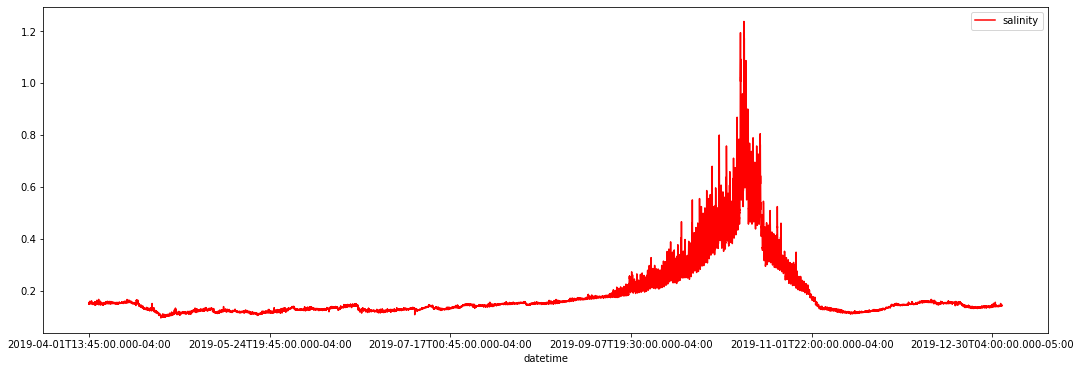

In [7]:
fig,ax1 = plt.subplots(figsize=(18,6))

df.plot(kind='line',y='salinity', color='red', ax=ax1)

## List of USGS Stations
Trenton, Pennypack Woods, Ben Franklin Bridge, Fort Mifflin, Chester, C&D canal, Reedy Point

#### List lat/lon


In [8]:
lons = [-1*(74+46/60+41/3600),-1*(74+59/60+37/3600),-1*(75+ 8/60+16/3600),-1*(75+12/60+11/3600),-1*(75+21/60+ 3/3600),-1*(75+37/60+ 7.9/3600),-1*(75+34/60+ 7/3600)]
lats = [   (40+13/60+18/3600),   (40+ 2/60+19/3600),   (39+57/60+14/3600),   (39+52/60+45/3600),   (39+50/60+44/3600),   (39+33/60+14.6/3600),   (39+30/60+ 3/3600)]
print(len(lons),len(lats))

7 7


In [9]:
import xarray as xr
import numpy as np

In [10]:
target_lon = xr.DataArray(lons, dims="points")
target_lat = xr.DataArray(lats, dims="points")

In [11]:
# Tide
## CHUNKING TO 100 ; ds['salt'] ~ 1.61 GB chunks - didn't work
## CHUNKING TO 80 ; ds['salt'] ~ 1.29 GB chunks - didn't work
## CHUNKING TO 60 ; ds['salt'] ~ 967 MB chunks - didn't work
## CHUNKING TO 50 ; ds['salt'] ~ 806 MB chunks - didn't work
## CHUNKING TO 40 ; ds['salt'] ~ 645 MB chunks - didn't work
## CHUNKING TO 30 ; ds['salt'] ~ 484 MB chunks - didn't work
## CHUNKING TO 20 ; ds['salt'] ~ 322 MB chunks - didn't work
## CHUNKING TO 10 ; ds['salt'] ~ 161 MB chunks - some distributed memory issues
## CHUNKING TO 8 ; ds['salt'] ~ 130 MB chunks 
## CHUNKING TO 5 ; ds['salt'] ~ 80 MB chunks 

ds = xr.open_mfdataset('/vortexfs1/share/usgs-share/users/scook/proj/DE_Bay/run07/run07C/testcoawst/ocean_deb_his_run07C_tsvar_testcoawst_000*.nc',
                       concat_dim='ocean_time',
                       data_vars='minimal', coords='minimal', compat='override',
                       parallel=True, chunks={'ocean_time':5})

In [12]:

ds1 = xr.open_mfdataset('/vortexfs1/share/usgs-share/users/scook/proj/DE_Bay/run07/run07C/testcoawst/tide/ocean_deb_his_run07C_tsvar_testcoawst_tide_000*.nc',
                       concat_dim='ocean_time',
                       data_vars='minimal', coords='minimal', compat='override',
                       parallel=True, chunks={'ocean_time':5})

ds2 = xr.open_mfdataset('/vortexfs1/share/usgs-share/users/scook/proj/DE_Bay/run07/run07C/testcoawst/bulk/obcfac/ocean_deb_his_run07C_tsvar_testcoawst_bulk_000*.nc',
                       concat_dim='ocean_time',
                       data_vars='minimal', coords='minimal', compat='override',
                       parallel=True, chunks={'ocean_time':5})


In [45]:
ds3 = xr.open_mfdataset('/vortexfs1/share/usgs-share/users/scook/proj/DE_Bay/run07/run07C/testcoawst/bulk_waves/ocean_deb_his_run07C_testcoawst_waves_000*.nc',
                       concat_dim='ocean_time',
                       data_vars='minimal', coords='minimal', compat='override',
                       parallel=True, chunks={'ocean_time':5})


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


In [13]:
# I want to find the speed at a certain lat/lon point.
lat = target_lat[4]
lon = target_lon[4]

# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(ds['lat_rho']-lat)
abslon = np.abs(ds['lon_rho']-lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

# Now I can use that index location to get the values at the x/y diminsion
point_ds = ds.isel(eta_rho=xloc, xi_rho=yloc)

### Now load dask client to load data

In [14]:
import dask.array as da

In [15]:
from dask.distributed import Client

In [16]:
client = Client()

In [17]:
client

Client Scheduler: tcp://127.0.0.1:39541 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 36 Memory: 64.42 GB


In [23]:
saltm = ds['salt'].isel(eta_rho=xloc, xi_rho=yloc).compute()

In [24]:
saltm1 = ds1['salt'].isel(eta_rho=xloc, xi_rho=yloc).compute()

In [25]:
saltm2 = ds2['salt'].isel(eta_rho=xloc, xi_rho=yloc).compute()

In [46]:
saltm3 = ds3['salt'].isel(eta_rho=xloc, xi_rho=yloc).compute()

distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [19]:
saltm

<xarray.DataArray 'salt' (ocean_time: 8642, s_rho: 16)>
array([[0.15006283, 0.15006283, 0.15006283, ..., 0.15006283, 0.15006283,
        0.15006283],
       [0.15010926, 0.15010926, 0.15010928, ..., 0.15010928, 0.15010928,
        0.15010928],
       [0.1500921 , 0.1500921 , 0.1500921 , ..., 0.1500921 , 0.1500921 ,
        0.1500921 ],
       ...,
       [0.10059852, 0.10059246, 0.1005884 , ..., 0.10057934, 0.10057934,
        0.10057933],
       [0.10000567, 0.10000594, 0.10000612, ..., 0.10000634, 0.10000634,
        0.10000634],
       [0.10016157, 0.10016157, 0.10016157, ..., 0.10016157, 0.10016157,
        0.10016157]], dtype=float32)
Coordinates:
  * s_rho       (s_rho) float64 -0.9688 -0.9062 -0.8438 ... -0.09375 -0.03125
    lon_rho     float64 -75.35
    lat_rho     float64 39.85
  * ocean_time  (ocean_time) datetime64[ns] 2019-01-01 ... 2019-12-27T01:00:00
Attributes:
    long_name:  salinity
    time:       ocean_time
    grid:       grid
    location:   face
    field:      salinity, scalar, series

(0.0, 0.88)

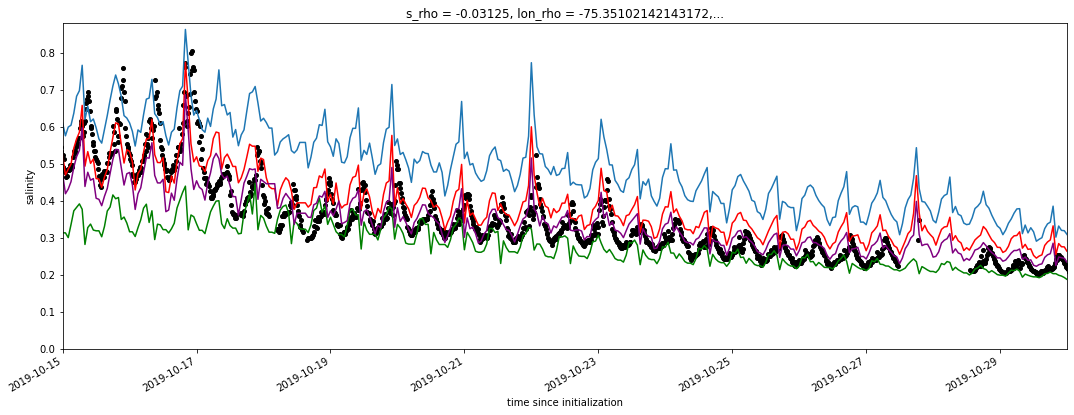

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [52]:
fig,ax1 = plt.subplots(figsize=(18,6))

plt.plot(df['date'],df['salinity'],'ko',markersize=4)
saltm.isel(s_rho=15).plot()
saltm1.isel(s_rho=15).plot(color='green')
saltm2.isel(s_rho=15).plot(color='red')
saltm3.isel(s_rho=15).plot(color='purple')

ax1.set_xlim([ds['ocean_time'].loc['2019-10-15 00:00:00'], ds['ocean_time'].loc['2019-10-30 00:00:00']])
ax1.set_ylim([0, 0.88])


## Calculate RMSE

In [21]:
from scipy.interpolate import interpn

In [22]:
test = xr.DataArray(df['salinity'],dims='ocean_time')
test = xr.DataArray(df['date'],dims='ocean_time')

In [23]:
test

<xarray.DataArray 'date' (ocean_time: 25272)>
array(['2019-04-01T17:45:00.000000000', '2019-04-01T18:00:00.000000000',
       '2019-04-01T18:15:00.000000000', ...,
       '2020-01-02T04:15:00.000000000', '2020-01-02T04:30:00.000000000',
       '2020-01-02T04:45:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) object '2019-04-01T13:45:00.000-04:00' ... '2020...

In [24]:
ds['ocean_time']

<xarray.DataArray 'ocean_time' (ocean_time: 8642)>
array(['2019-01-01T00:00:00.000000000', '2019-01-01T01:00:00.000000000',
       '2019-01-01T02:00:00.000000000', ..., '2019-12-26T23:00:00.000000000',
       '2019-12-27T00:00:00.000000000', '2019-12-27T01:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2019-01-01 ... 2019-12-27T01:00:00
Attributes:
    long_name:  time since initialization
    field:      time, scalar, series

In [25]:
date

NameError: name 'date' is not defined

In [ ]:
test2 = test.interp(ocean_time=date, method="linear")

In [ ]:
test = xr.DataArray(df['date'],dims='ocean_time')
test2 = saltm.isel(s_rho=15).interp(ocean_time=test, method="linear")

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [ ]:
MSE = np.square(np.subtract(df['salinity'],test2)).mean() 

In [ ]:
MSE

In [ ]:
plt.plot(df['date'],df['salinity'])
plt.plot(df['date'],test2)

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took